

Here we will figure out what fraction of the solid angle inside the Airy disk is actually summed up in an observation.
It's less than the total solid angle inside the disk, because the response keeps falling off from the center to the
zero crossing.



In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
from astropy import units as u
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats




So this means that we really should be getting only 22.8% of the power we would get if we had 100% response across the whole Airy disk, which has angular radius 1.22(lambda/D) = 1.22(0.21m / 1.8m) = 0.142 radians or 8.16 degrees.  Now since solid angle goes roughly as angular radius squared (for small angles), our integrated response out to the Airy radius is equivalent to the response of a cone that has 100% response out to the edge but has radius:

sqrt(0.228) * 8.16 degrees = 3.90 degrees

So this is the angular radius I will feed into the HEASARC column density tool at 
https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3nh/w3nh.pl


In [2]:
def readcsv(file):
    df = pd.read_csv('Radio/'+file+'.csv')#
    df = pd.DataFrame(df, columns=['Frequecncy(Hz)', 'Amplitude(dBm)' ])
    df = np.array(df)
    F = [d[0] for d in df]
    A = [d[1] for d in df]
    return(F,A)
#going from log db type to regular linear Watts. Adding 3dB for cable attenuation
def dbmtow(A):
    
    A = A+3#cable attenuation = 3dB
    A = A/37 #LNA Gain = 37dB, dividing gives power into LNA
    A = 10**((A+3)/10)/1000 #dBm to W
    A = A*(.001/30) #W/RBW to W/kHz to W/Hz for RBW
    A = 2*A #"factor of 2" in Watts or dB? going with linear factor of Watts value
    return A


In [3]:
F48, A48 = readcsv('TRACE048')
F49, A49 = readcsv('TRACE049')
F50, A50 = readcsv('TRACE050')
F51, A51 = readcsv('TRACE051')
F52, A52 = readcsv('TRACE052')
F53, A53 = readcsv('TRACE053')
F54, A54 = readcsv('TRACE054')
F55, A55 = readcsv('TRACE055')
F56, A56 = readcsv('TRACE056')
F57, A57 = readcsv('TRACE057')
F58, A58 = readcsv('TRACE058')
F59, A59 = readcsv('TRACE059')



In [4]:
print(A48[0:9])
#Making conversion from dBm to W
A48 = dbmtow(np.array(A48))
A49 = dbmtow(np.array(A49))
A50 = dbmtow(np.array(A50))
A51 = dbmtow(np.array(A51))
A52 = dbmtow(np.array(A52))
A53 = dbmtow(np.array(A53))
A54 = dbmtow(np.array(A54))
A55 = dbmtow(np.array(A55))
A56 = dbmtow(np.array(A56))
A57 = dbmtow(np.array(A57))
A58 = dbmtow(np.array(A58))
A59 = dbmtow(np.array(A59))

F48 = np.array(F48)
F49 = np.array(F49)
F50 = np.array(F50)
F51 = np.array(F51)
F52 = np.array(F52)
F53 = np.array(F53)
F54 = np.array(F54)
F55 = np.array(F55)
F56 = np.array(F56)
F57 = np.array(F57)
F58 = np.array(F58)
F59 = np.array(F59)
#making conversion from RBW to Hz
#A48 = rbwtohz(np.array(A48))
#A49 = rbwtohz(np.array(A49))
#A50 = rbwtohz(np.array(A50))
#A51 = rbwtohz(np.array(A51))
#A52 = rbwtohz(np.array(A52))
#53 = rbwtohz(np.array(A53))
#A54 = rbwtohz(np.array(A54))
#A55 = rbwtohz(np.array(A55))
#A56 = rbwtohz(np.array(A56))
#A57 = rbwtohz(np.array(A57))
#A58 = rbwtohz(np.array(A58))
#59 = rbwtohz(np.array(A59))



Fs = [F48, F49, F50, F51, F52, F53, F54, F55, F56, F57, F58, F59]
As = [A48, A49, A50, A51, A52, A53, A54, A55, A56, A57, A58, A59]
print(A48[0:9])

[-104.1319122, -104.0623016, -103.9863281, -103.9841843, -104.0634689, -104.1089249, -103.9323044, -103.9239349, -103.9386826]
[7.08890650e-08 7.09197809e-08 7.09533196e-08 7.09542662e-08
 7.09192657e-08 7.08992068e-08 7.09771782e-08 7.09808751e-08
 7.09743609e-08]


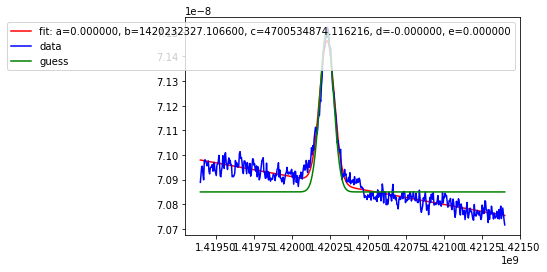

In [57]:
#guess gaussian+linear+constant
def func(x, a, b,c,d,e):
    return a*np.exp(-((x-b)**2)/(c))+d*x+e
#next line from curve_fit documentation. p0=(guess values)
popt, pcov = curve_fit(func, Favg, Aavg, p0=(0.065*1e-8,1.420230*1e9,4.0*1e9,0,7.085*1e-8))# bounds=(0, [.5, ,.5, 1., 0.5]))
plt.plot(F48, func(F48, *popt), 'r-',
         label='fit: a=%f, b=%f, c=%f, d=%f, e=%f' % tuple(popt))
#feeding my x values into my function with guess values
guess = func(F48, a=0.065*1e-8, b=1.420230*1e9, c=4.0*1e9, d=0, e=7.085*1e-8)
plt.plot(F48, A48, 'b-', label='data')
plt.plot(F48, guess, 'g-', label='guess')
plt.legend()
plt.show()

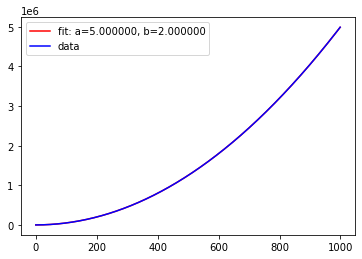

In [6]:
x = np.arange(0,1000)
y = 5*x**2+2
def func(x, a, b):
    return a*x**2+b
def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
Favg = moving_average(F48)
Aavg = moving_average(A48)
popt, pcov = curve_fit(func, x, y)# bounds=(0, [.5, ,.5, 1., 0.5]))
plt.plot(x, func(x, *popt), 'r-',
         label='fit: a=%f, b=%f' % tuple(popt))
plt.plot(Favg, Aavg, 'b-', label='avg')
plt.plot(x, y, 'b-', label='data')
plt.legend()
plt.show()

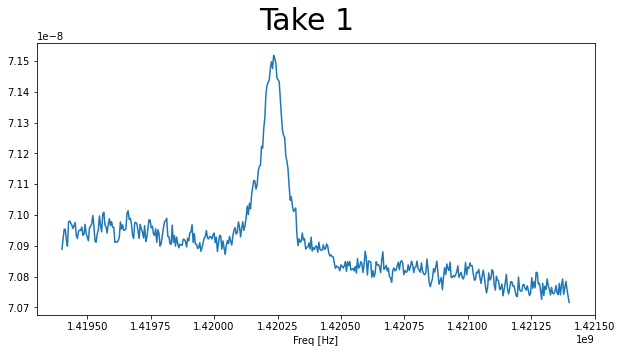

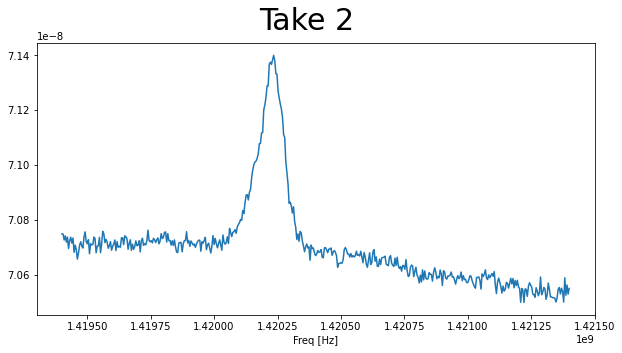

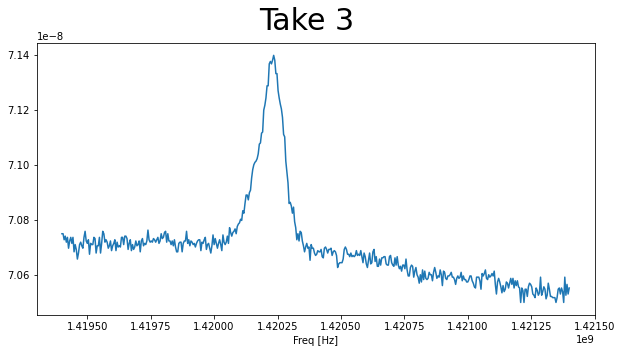

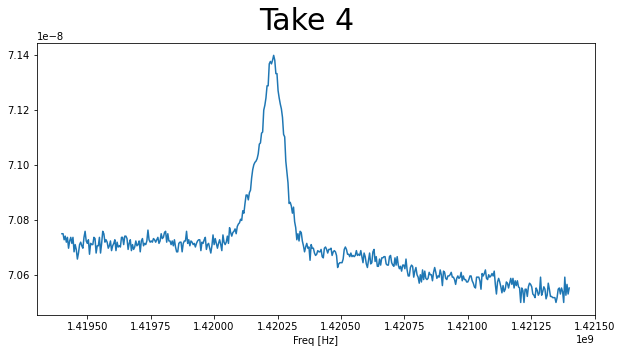

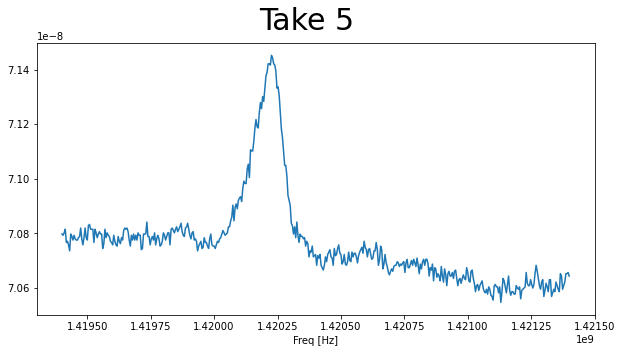

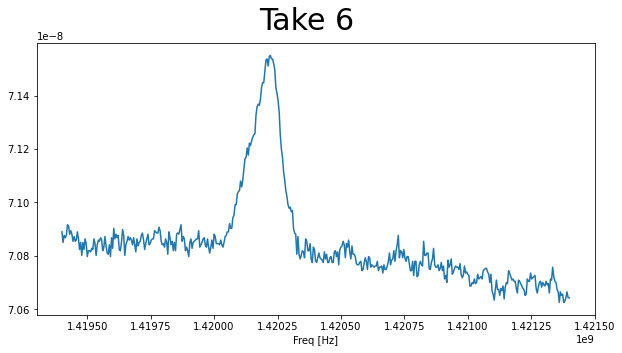

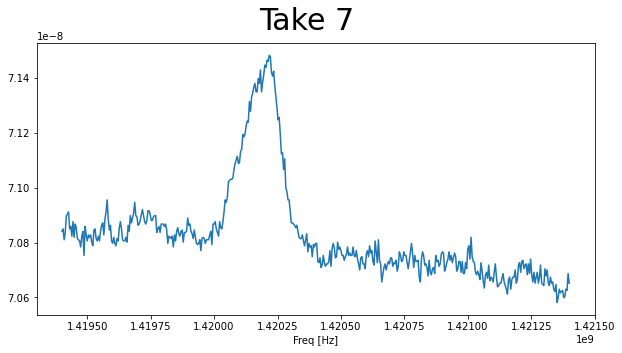

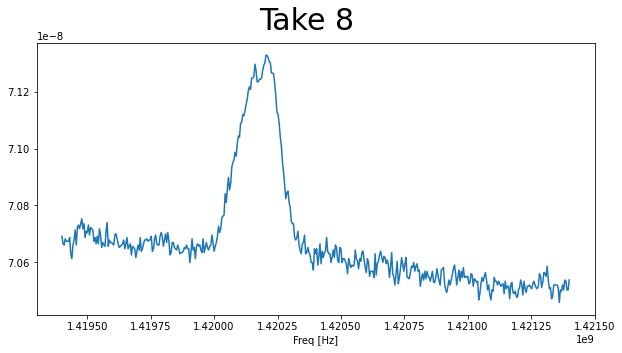

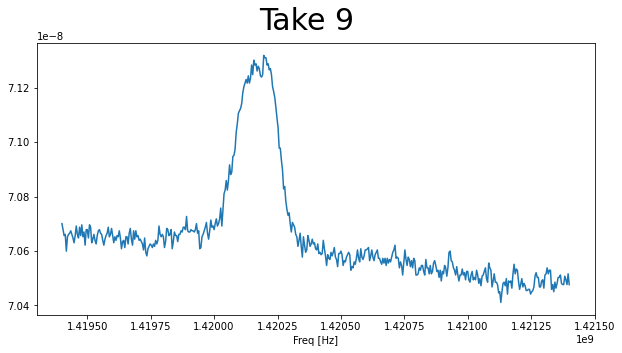

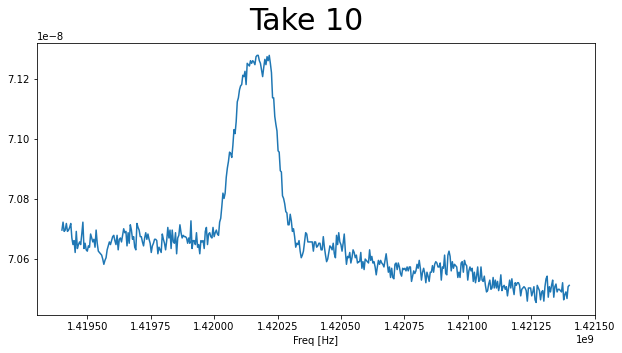

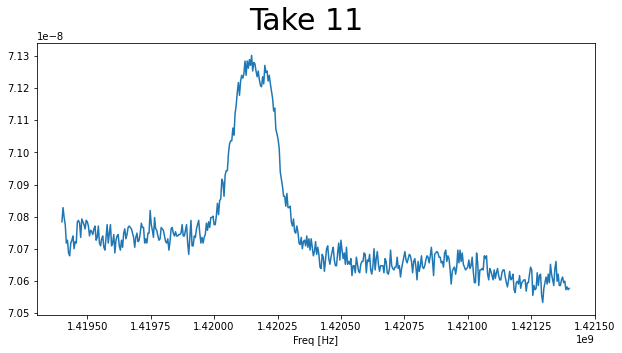

In [7]:

for i in range(11):
    fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
    im2=ax2.plot(Fs[i], As[i])
    ax2.set_xlabel('Freq [Hz]')

    plt.suptitle(f"Take {i+1}", fontsize=30)
    #plt.savefig(f'{int(Micrometer[micron]*100)}nm_solspec.png')
    plt.show()